In [1]:
import torch
import numpy as np
import normflows as nf

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.dirname(c_directory))
sys.path.append(os.path.join(os.path.dirname(c_directory), 'BSCD'))

import FCBSCD_simulator

from matplotlib import pyplot as plt
from eZplot import FCBSCD_plot
from tqdm import tqdm

N = 2**12

seed_data = 42
seed_mcmc= 42
torch.manual_seed(seed_mcmc)


enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FCBSCD_simulator.adjust_device(device)

model_file = 'FCBSCD_network.pt'

In [2]:
os.path.join(os.path.dirname(c_directory), 'BSCD')

'/home/pessoa/Codes/SBI-posterior/BSCD'

In [3]:
# Define target
target = FCBSCD_simulator.target()
context_size = 6

In [4]:
# Define flows
latent_size = 1
latent_size = 1
hidden_units = 128
hidden_layers = 5

flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 512,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1)#, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

In [5]:
try:
    model.load_state_dict(torch.load(model_file))
    #model.eval()  # Set the model to evaluation mode
    print('loading pretrained network')
except:
    print('starting from scratch')

loading pretrained network


In [6]:
dv = np.loadtxt('FCBSCD_synth/gt_map.csv')
gt = torch.tensor( dv[ dv[:,0]==seed_data ][0,1:] , device=device,dtype=torch.float)

x = np.loadtxt('FCBSCD_synth/synth_{}.csv'.format(seed_data))[:N]
x = torch.tensor(x,device=device,dtype=torch.float).reshape(-1,1)
gt

tensor([ 5.3367,  8.1288,  0.2345,  0.2303, -2.5807, -0.3727], device='cuda:0')

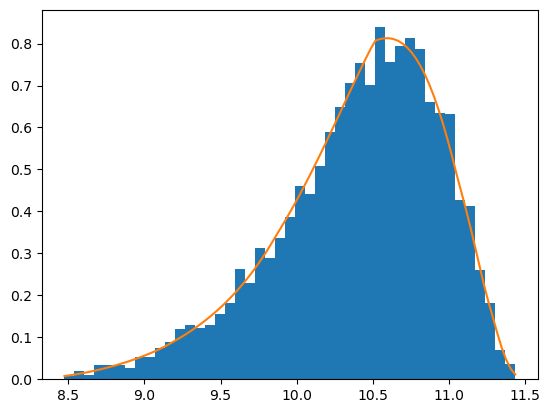

In [7]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=45)

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu())

In [8]:
vectorize_params = torch.ones(1024,5).to(device)

def log_likelihood(data,params,model):
    global vectorize_params
    if data.size !=  vectorize_params.size(0):
        vectorize_params = torch.ones((data.size(0),6),device=device)

    return model.log_prob(data,params*vectorize_params)

def log_post(data,params,model,lprior):
    return log_likelihood(data,params,model).sum() + lprior(params)


In [9]:
lp_gt = log_post(x,gt,model,target.log_prior)
lp_gt

tensor(-2965.3464, device='cuda:0', grad_fn=<AddBackward0>)

In [10]:
#first 100 from prior
params_100 = target.sample(n=100)[:,1:]
best_param = params_100[0]
lp_max = log_post(x,best_param,model,target.log_prior)

for par in params_100[1:]:
    lp_par = log_post(x,par,model,target.log_prior)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par

for i in range(3,8):

    params_100 = (target.sample(n=100)[:,1:] - best_param)/i +best_param

    for par in params_100:
        lp_par = log_post(x,par,model,target.log_prior)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 4.8309,  8.3802, -0.4816, -0.8671, -2.4548, -0.6791], device='cuda:0') tensor(-3484.9592, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 4.8437,  8.8420, -0.4069, -0.8461, -2.5031, -1.1882], device='cuda:0') tensor(-3352.6899, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 4.7423,  8.5986, -0.1056, -0.8098, -2.2837, -1.0704], device='cuda:0') tensor(-3201.7368, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 5.1449,  8.5264,  0.0832, -0.5294, -2.2786, -0.9793], device='cuda:0') tensor(-3114.2678, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 5.3250,  8.2433,  0.0515, -0.1875, -2.3534, -0.6245], device='cuda:0') tensor(-3027.9807, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 5.3249,  8.0284,  0.0738, -0.0577, -2.3978, -0.2809], device='cuda:0') tensor(-3002.8479, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 5.2533,  7.9937,  0.0521, -0.1235, -2.4243, -0.2824], device='cuda:0') tensor(-2990.1963, device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 5.3648e+00,

In [11]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [12]:
S = torch.eye(context_size)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(context_size,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(context_size,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [13]:
count_of_safe=0
loopruns = 0

while count_of_safe <=10:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,model,target.log_prior)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-100:]).T.cov() + torch.eye(context_size)*1e-10) * (2.4**2/(context_size)) )
    loopruns+=1

    print(loopruns,acc_rate)
    



1 0.35
2 0.32
3 0.43
4 0.61
5 0.6
6 0.5
7 0.46
8 0.59
9 0.4
10 0.45
11 0.35
12 0.47
13 0.37
14 0.31
15 0.46
16 0.44
17 0.44
18 0.39
19 0.45


In [14]:
sampled_params

[tensor([ 5.3771,  7.9764,  0.1280, -0.1147, -2.4103, -0.3317]),
 tensor([ 5.3703,  7.9930,  0.1411, -0.1148, -2.4187, -0.3375]),
 tensor([ 5.3570,  8.0040,  0.1400, -0.1159, -2.4263, -0.3378]),
 tensor([ 5.3407,  7.9994,  0.1334, -0.1225, -2.4108, -0.3286]),
 tensor([ 5.3378,  7.9958,  0.1236, -0.1199, -2.4170, -0.3204]),
 tensor([ 5.3378,  7.9958,  0.1236, -0.1199, -2.4170, -0.3204]),
 tensor([ 5.3381,  7.9845,  0.1064, -0.1201, -2.4235, -0.3294]),
 tensor([ 5.3547,  7.9912,  0.1037, -0.1207, -2.4139, -0.3308]),
 tensor([ 5.3623,  7.9963,  0.1288, -0.1038, -2.3961, -0.3169]),
 tensor([ 5.3623,  7.9963,  0.1288, -0.1038, -2.3961, -0.3169]),
 tensor([ 5.3557,  7.9934,  0.1261, -0.1073, -2.4029, -0.3194]),
 tensor([ 5.3557,  7.9934,  0.1261, -0.1073, -2.4029, -0.3194]),
 tensor([ 5.3561,  7.9912,  0.1292, -0.1213, -2.3909, -0.3247]),
 tensor([ 5.3798,  7.9899,  0.1339, -0.1098, -2.3931, -0.3334]),
 tensor([ 5.4025,  7.9936,  0.1211, -0.1308, -2.4006, -0.3301]),
 tensor([ 5.4025,  7.9936

In [15]:
param

tensor([ 6.0531,  8.5158,  0.0529, -0.0408, -2.3177, -0.8067], device='cuda:0')

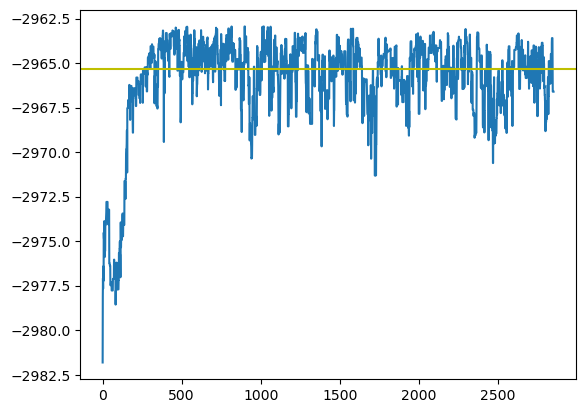

In [16]:
plt.plot(sampled_logpost)
plt.axhline(lp_gt.item(),color='y')

In [17]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,model,target.log_prior)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 5.5605,  8.1872,  0.1487,  0.0915, -2.2365, -0.4682], device='cuda:0') tensor(-2963.4392, device='cuda:0', grad_fn=<AddBackward0>)
199 tensor([ 5.6901e+00,  8.2027e+00,  1.5228e-01,  5.8223e-03, -2.5131e+00,
        -5.0078e-01], device='cuda:0') tensor(-2968.2932, device='cuda:0', grad_fn=<AddBackward0>)
299 tensor([ 5.3663,  7.9916,  0.2472,  0.2183, -2.5811, -0.2612], device='cuda:0') tensor(-2970.2915, device='cuda:0', grad_fn=<AddBackward0>)
399 tensor([ 4.6868,  7.3291,  0.1683,  0.0605, -2.3442,  0.3701], device='cuda:0') tensor(-2964.3284, device='cuda:0', grad_fn=<AddBackward0>)
499 tensor([ 5.1769e+00,  7.7057e+00,  7.3996e-02, -2.4922e-02, -2.5343e+00,
        -1.6485e-03], device='cuda:0') tensor(-2965.0789, device='cuda:0', grad_fn=<AddBackward0>)
599 tensor([ 5.1266,  7.9113,  0.2092,  0.0422, -2.2855, -0.2248], device='cuda:0') tensor(-2968.7798, device='cuda:0', grad_fn=<AddBackward0>)
699 tensor([ 4.9298,  7.6972,  0.2438,  0.2350, -2.3201,  0.0464], device

KeyboardInterrupt: 

In [ ]:
np.savetxt('FCBSCD_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed_mcmc,seed_data,N),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

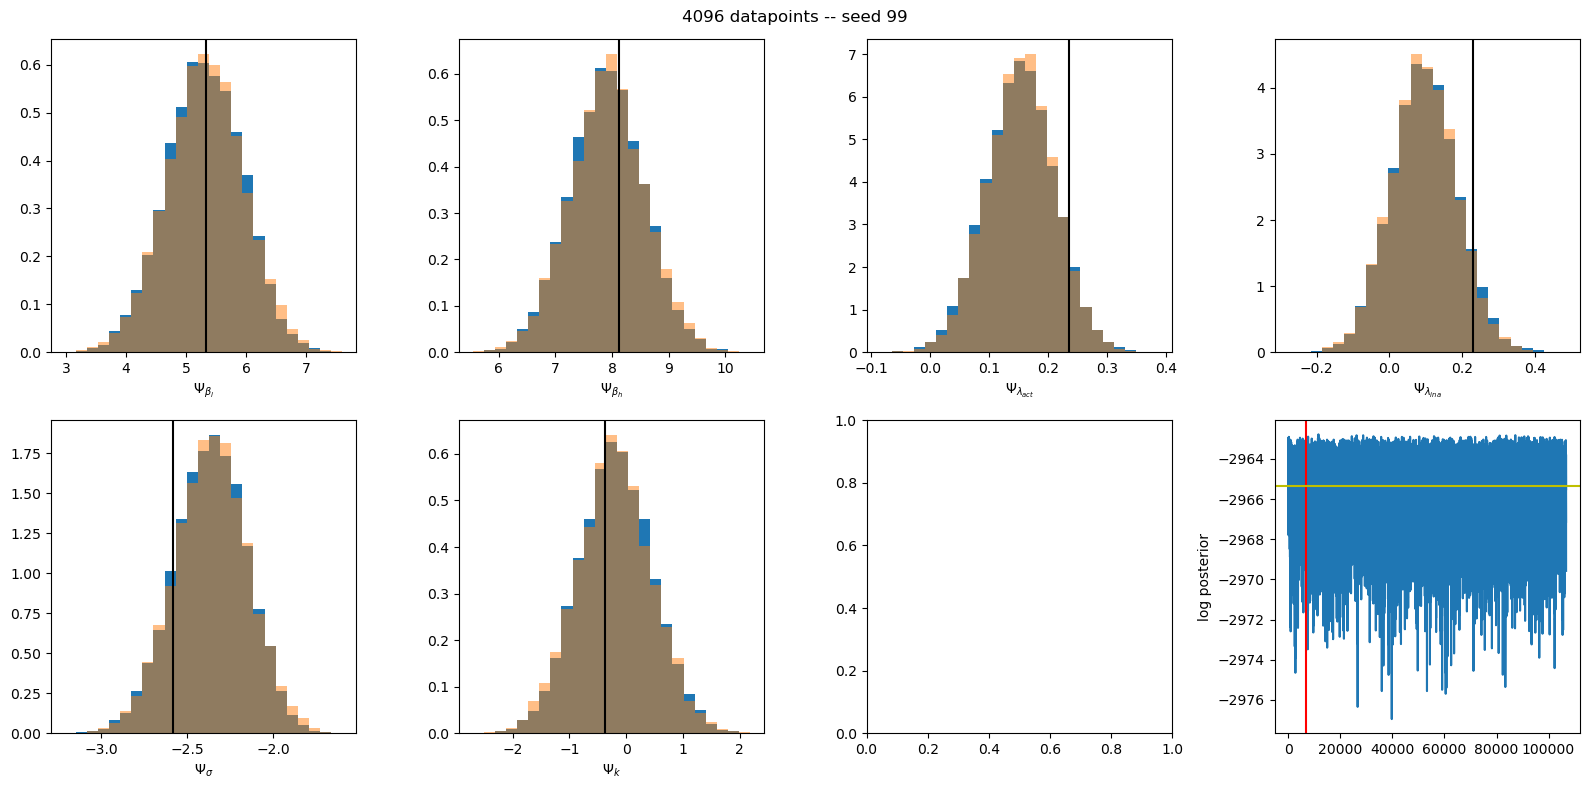

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
labels = [r'$\Psi_{\beta_l}$',r'$\Psi_{\beta_h}$',r'$\Psi_{\lambda_{act}}$',r'$\Psi_{\lambda_{ina}}$',r'$\Psi_\sigma$',r'$\Psi_k$']
sp = torch.stack(sampled_params).numpy()

for (i,axi) in zip(range(6),np.concatenate((ax))):
    his = axi.hist(sp[burnin:burnin+sp.shape[0]//2,i],density=True,bins=25)
    axi.hist(sp[burnin+sp.shape[0]//2:,i],density=True,bins=his[1],alpha=.5)
    #axi.hist(sp[burnin:,i],density=True,bins=25)
    axi.axvline(gt.cpu()[i].item(),color='k')
    axi.set_xlabel(labels[i])

ax[-1][-1].plot(sampled_logpost)
ax[-1][-1].axvline(burnin,color='red')
ax[-1][-1].axhline(lp_gt.item(),color='y')

ax[-1][-1].set_ylabel('log posterior')

plt.suptitle('{} datapoints -- seed {}'.format(N,seed_mcmc))

plt.tight_layout()
plt.savefig('FCBSCD_inf_figs/mcmc_noncentral_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)

In [ ]:
map_param = sampled_params[np.argmax(sampled_logpost)].to(device)

In [ ]:
map_param

tensor([ 5.3113,  7.9003,  0.1512,  0.0823, -2.3700, -0.1829], device='cuda:0')

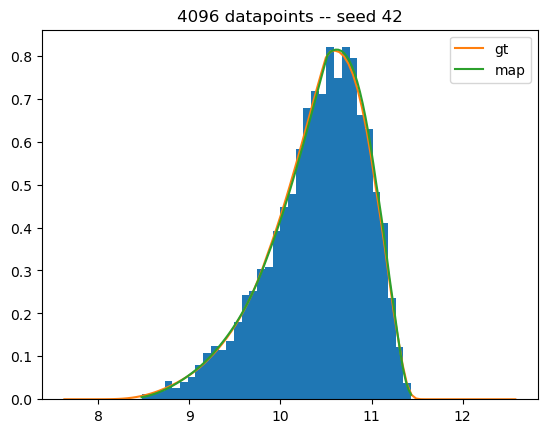

In [ ]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=35)

xp = torch.linspace(.9*x.min(),1.1*x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='gt')

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*map_param)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='map')
plt.legend()

plt.title('{} datapoints -- seed {}'.format(N,seed_data))

plt.savefig('FCBSCD_inf_figs/mcmc_compare_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)